In [9]:
#https://colab.research.google.com/drive/14OvFnAXggxB8vM4e8vSURUp1TaKnovzX?usp=sharing
# Install required packages.
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

You should consider upgrading via the 'C:\Users\1\PycharmProjects\pythonProject4\venv\Scripts\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'C:\Users\1\PycharmProjects\pythonProject4\venv\Scripts\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'C:\Users\1\PycharmProjects\pythonProject4\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [10]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [11]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


c:\users\1\pycharmprojects\pythonproject4\venv\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\users\1\pycharmprojects\pythonproject4\venv\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


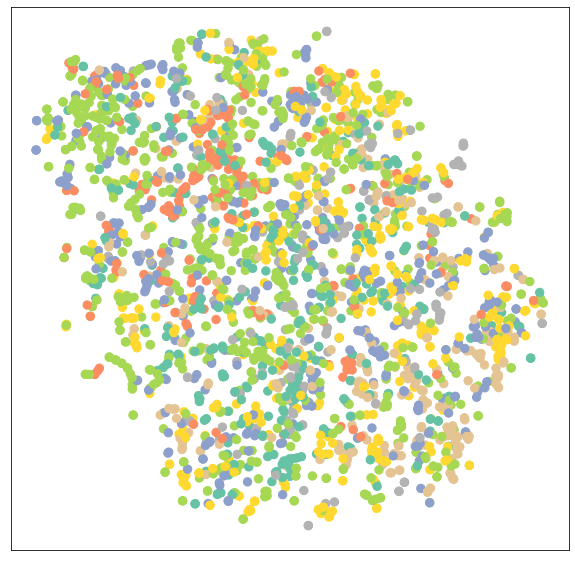

In [12]:
model = GCN(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [21]:
from torch_geometric.nn import GATConv


class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(1234567)
        # self.conv1 = GATConv(dataset.num_features, hidden_channels,heads)  # TODO
        # self.conv2 = GATConv(hidden_channels, dataset.num_classes,heads)  # TODO
        self.conv1 = GATConv(dataset.num_features, hidden_channels,heads)  # TODO
        self.conv2 = GATConv(hidden_channels*hidden_channels, dataset.num_classes,heads)  # TODO

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GAT(hidden_channels=8, heads=8)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
      acc = int(correct.sum()) / int(mask.sum())  # Derive ratio of correct predictions.
      return acc


for epoch in range(1, 801):
    loss = train()
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

GAT(
  (conv1): GATConv(1433, 8, heads=8)
  (conv2): GATConv(64, 7, heads=8)
)
Epoch: 001, Loss: 4.0245, Val: 0.1540, Test: 0.1660
Epoch: 002, Loss: 3.9907, Val: 0.1240, Test: 0.1310
Epoch: 003, Loss: 3.9534, Val: 0.0960, Test: 0.1100
Epoch: 004, Loss: 3.9121, Val: 0.0860, Test: 0.1020
Epoch: 005, Loss: 3.8659, Val: 0.0840, Test: 0.0920
Epoch: 006, Loss: 3.8015, Val: 0.0780, Test: 0.0890
Epoch: 007, Loss: 3.7434, Val: 0.0680, Test: 0.0800
Epoch: 008, Loss: 3.6690, Val: 0.0660, Test: 0.0760
Epoch: 009, Loss: 3.6004, Val: 0.0640, Test: 0.0740
Epoch: 010, Loss: 3.5158, Val: 0.0640, Test: 0.0720
Epoch: 011, Loss: 3.4187, Val: 0.0620, Test: 0.0710
Epoch: 012, Loss: 3.3205, Val: 0.0600, Test: 0.0690
Epoch: 013, Loss: 3.2355, Val: 0.0580, Test: 0.0670
Epoch: 014, Loss: 3.1221, Val: 0.0580, Test: 0.0670
Epoch: 015, Loss: 2.9988, Val: 0.0580, Test: 0.0670
Epoch: 016, Loss: 2.8735, Val: 0.0580, Test: 0.0660
Epoch: 017, Loss: 2.7678, Val: 0.0580, Test: 0.0660
Epoch: 018, Loss: 2.6441, Val: 0.0580

In [20]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

TypeError: test() missing 1 required positional argument: 'mask'